In [2]:
import os
print(os.getcwd())

c:\Users\emohaub\ML-for-5G-TSN-DetNet-Integration\ml-frer


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the CSV file
df = pd.read_csv('./CSV/2023-02-15-OTA-UE1.csv')

# # Inspect the first few rows of the dataframe
# print(df.head())

original_df = df.copy()



# Drop the 'Time' column as it's not used for clustering
df.drop('Time', axis=1, inplace=True)

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(scaled_features)

# Cluster labels
df['Cluster'] = kmeans.labels_

# Calculate silhouette score
score = silhouette_score(scaled_features, kmeans.labels_)

print(df)
print("Silhouette Score:", score)

     <RSRP>  <RSRQ>  <SINR>  Cluster
0       -55     -11      34        1
1       -55     -11      33        1
2       -56     -11      33        1
3       -56     -11      33        1
4       -56     -11      33        1
..      ...     ...     ...      ...
786     -78     -11      23        0
787     -83     -11      22        0
788     -83     -11      22        0
789     -83     -11      22        0
790     -86     -12      22        2

[791 rows x 4 columns]
Silhouette Score: 0.7387713967926642


### We need to know which cluster is green, red or orange.

In [5]:
# Calculate and print the centroids
centroids = kmeans.cluster_centers_

inverse_centroids = scaler.inverse_transform(centroids)
print(f"\n\ninverse_centroids:\n{inverse_centroids}")




inverse_centroids:
[[-79.88888889 -11.          23.75      ]
 [-62.42218543 -11.          32.17384106]
 [-83.28571429 -12.          23.14285714]]


### Centroid Interpretation


- The calculated centroids represent the average values for RSRP, RSRQ, and SINR in each of the three clusters after applying inverse transformation to scale them back to their original units. These centroids can be interpreted as follows:

### 1st Centroid:
- **RSRP**: -79.88 dBm  
- **RSRQ**: -11 dB  
- **SINR**: 23.75 dB  
This cluster has moderate RSRP and SINR values, suggesting modest network conditions. It falls in the middle of the range for the signal quality metrics and can be categorized as **Orange**.

### 2nd Centroid:
- **RSRP**: -62.42 dBm  
- **RSRQ**: -11 dB  
- **SINR**: 32.17 dB
This cluster represents the highest quality signals among the three clusters, with relatively high SINR and better RSRP values. It can be categorized as **Green**, indicating good network conditions.

### 3rd Centroid:
- **RSRP**: -83.28 dBm  
- **RSRQ**: -12 dB  
- **SINR**: 23.14 dB  
This cluster represents the lowest quality signals, with the lowest RSRP and slightly lower SINR values compared to the second cluster.  
The RSRQ is also slightly worse. This cluster can be categorized as **Red**, indicating poor network conditions.

##### Summary of Cluster Categories
- **Green Cluster**: Best signal quality, ideal network conditions. Actions may include maintaining current configurations without the need for FRER replication.
- **Orange Cluster**: Moderate signal quality, acceptable network conditions but with room for improvement. Actions might be conditional, depending on other factors such as traffic type or data criticality.
- **Red Cluster**: Poor signal quality, indicating potential issues or challenging conditions. This might necessitate enabling FRER replication to ensure data reliability.


- The inverse centroids are ordered as Orange, Green, Red.


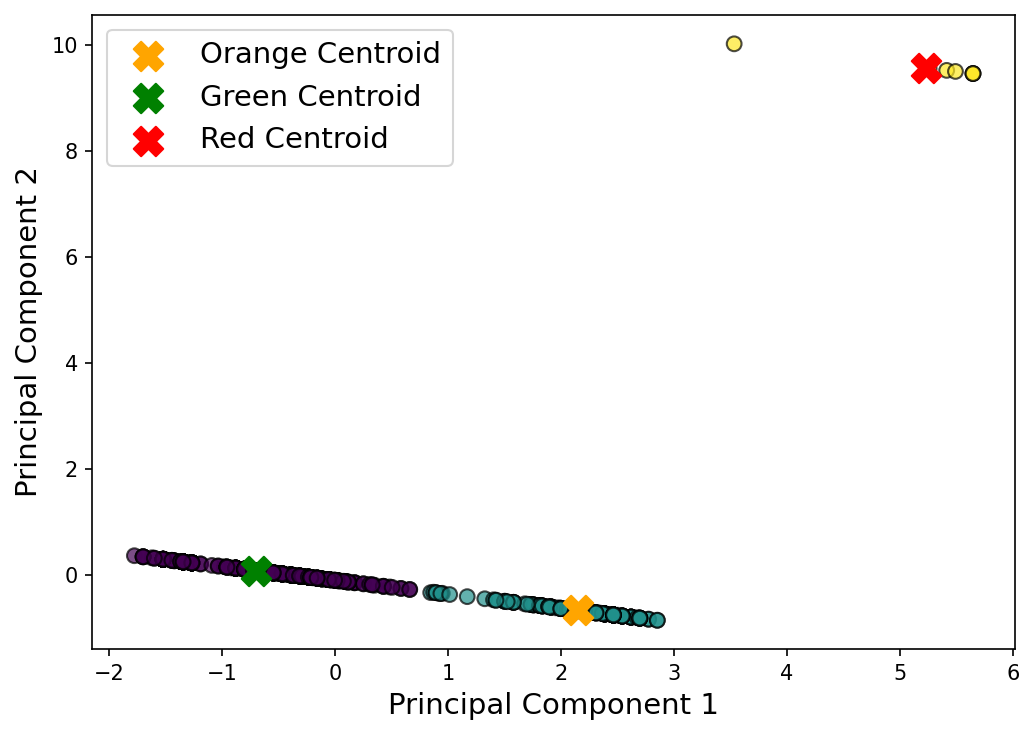

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce data to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the reduced data with cluster labels
plt.figure(figsize=(7, 5), dpi=150)
plt.scatter(-1*reduced_features[:, 0], -1*reduced_features[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7)
# plt.title('Cluster Visualization in 2D with PCA')
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)

# Centroids reduced for visualization
centroids_reduced = pca.transform(kmeans.cluster_centers_)

# Colors and labels for each cluster
colors = ['orange', 'green',  'red']
labels = ['Orange', 'Green',  'Red']

# Plot and label centroids
for i, centroid in enumerate(centroids_reduced):
    plt.scatter(-1*centroid[0], -1*centroid[1], color=colors[i], marker='X', s=200, label=f'{labels[i]} Centroid')

plt.legend(fontsize=14)


plt.tight_layout()
# plt.savefig("cluster_vis_pca.pdf")


plt.show()

In [14]:
# Assuming 'pca' is your PCA instance
print(pca.components_)

# For more detailed interpretation
for i, component in enumerate(pca.components_):
    print(f"Principal Component {i+1}:")
    for weight, feature in zip(component, df):
        print(f"{feature}: {weight:.4f}")
    print("\n")


[[ 0.68433749  0.25435427  0.68336382]
 [-0.17570767  0.96709343 -0.184003  ]]
Principal Component 1:
<RSRP>: 0.6843
<RSRQ>: 0.2544
<SINR>: 0.6834


Principal Component 2:
<RSRP>: -0.1757
<RSRQ>: 0.9671
<SINR>: -0.1840




In [26]:
import numpy as np

# Assuming RSRP is the first column in your centroids, sort the centroids by RSRP
# The sorted array will have indices of centroids from highest to lowest RSRP
sorted_indices = np.argsort(-inverse_centroids[:, 2])

# Define colors in the desired order: highest RSRP to Green, middle to Orange, lowest to Red
colors = ['Green', 'Orange', 'Red']
  
# Create a mapping from old cluster labels to new labels based on RSRP ranking
# The sorted_indices array indicates the order of centroids from highest to lowest RSRP
label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_indices)}

# Apply the mapping to the DataFrame's cluster labels
df['Cluster'] = df['Cluster'].map(label_mapping)

# Now, df['Cluster'] contains 0 for the highest RSRP (Green), 1 for the middle (Orange), and 2 for the lowest (Red)
print(df)

     <RSRP>  <RSRQ>  <SINR>  Cluster
0       -55     -11      34        0
1       -55     -11      33        0
2       -56     -11      33        0
3       -56     -11      33        0
4       -56     -11      33        0
..      ...     ...     ...      ...
786     -78     -11      23        1
787     -83     -11      22        1
788     -83     -11      22        1
789     -83     -11      22        1
790     -86     -12      22        2

[791 rows x 4 columns]


In [27]:
print(sorted_indices) #### For simplicity, Green is considered 0, Orange, 1, and Red 2 in the following code:


[1 0 2]


In [17]:
# Assuming 'original_df' is the DataFrame before dropping the 'Time' column
original_df['Cluster'] = df['Cluster']  # Add the cluster labels to the original DataFrame

# Save the updated DataFrame including 'Time' and 'Cluster' to a new CSV file
original_df.to_csv('./CSV/2023-02-15-OTA-UE1_with_clusters.csv', index=False)


### PCA in 3D

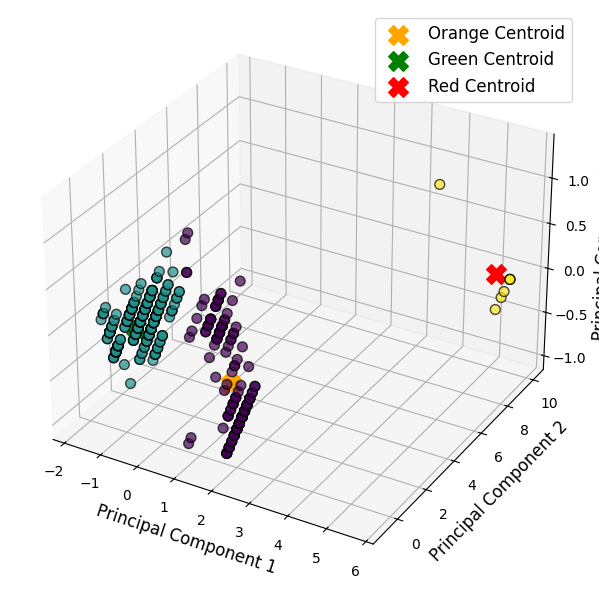

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This is necessary for 3D plotting
from sklearn.decomposition import PCA

# Apply PCA to reduce data to 3 dimensions for better visualization
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(scaled_features)

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # Adding a 3D subplot

# Scatter plot for each cluster in 3D
scatter = ax.scatter(-1*reduced_features[:, 0], -1*reduced_features[:, 1], -1*reduced_features[:, 2], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7)

# Labeling axes
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_zlabel('Principal Component 3', fontsize=12)

# Centroids reduced for 3D visualization
centroids_reduced = pca.transform(kmeans.cluster_centers_)

# Colors and labels for each cluster
colors = ['orange', 'green', 'red']
labels = ['Orange', 'Green', 'Red']

# Plot and label centroids in 3D
for i, centroid in enumerate(centroids_reduced):
    ax.scatter(-1*centroid[0], -1*centroid[1], -1*centroid[2], color=colors[i], marker='X', s=200, label=f'{labels[i]} Centroid')

ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [33]:
import plotly.express as px
from sklearn.decomposition import PCA

# Apply PCA to reduce data to 3 dimensions for better visualization
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(scaled_features)

# Creating a DataFrame for the Plotly visualization
plotly_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2', 'PC3'])
plotly_df['Cluster'] = df['Cluster'].map({0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'})  # Mapping cluster numbers to names

# Plotting in 3D with Plotly
fig = px.scatter_3d(plotly_df, x='PC1', y='PC2', z='PC3', color='Cluster', labels={'Cluster': 'Cluster Label'},
                    title="3D PCA Cluster Visualization", opacity=0.7)

# Centroids reduced for 3D visualization
centroids_reduced = pca.transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids_reduced, columns=['PC1', 'PC2', 'PC3'])
centroids_df['Cluster'] = ['Cluster 1 Centroid', 'Cluster 2 Centroid', 'Cluster 3 Centroid']

# Adding centroids to the plot
for i, row in centroids_df.iterrows():
    fig.add_trace(px.scatter_3d(centroids_df.iloc[[i]], x='PC1', y='PC2', z='PC3', color=centroids_df.iloc[[i]]['Cluster']).data[0])

fig.show()


# Testing New Radio Measurements

In [21]:
# Load the new data
new_df = pd.read_csv('./CSV/2023-02-15-OTA-UE0.csv')

# Inspect the first few rows of the dataframe
print(f"new measurement:\n{new_df.head(3)}")

original_new_df = new_df.copy()
# Drop the 'Time' column as it's not used for clustering
new_df.drop('Time', axis=1, inplace=True)

# Assuming 'scaler' is the previously fitted StandardScaler instance

# Normalize the features of the new data, excluding 'Time' if it exists
new_scaled_features = scaler.transform(new_df)


# Assuming 'kmeans' is the previously trained KMeans instance

# Predict cluster assignments for the new data
new_df['Cluster'] = kmeans.predict(new_scaled_features)

print(f"\n New measurement clustered:\n{new_df.head(3)}")


new_df['Cluster'] = new_df['Cluster'].map(label_mapping)
print(f"\nMapped New Measurement:\n{new_df.head(3)}")


new measurement:
       Time  <RSRP>  <RSRQ>  <SINR>
0  23:50:55     -58     -11      32
1  23:50:56     -57     -11      31
2  23:50:57     -57     -11      31

 New measurement clustered:
   <RSRP>  <RSRQ>  <SINR>  Cluster
0     -58     -11      32        1
1     -57     -11      31        1
2     -57     -11      31        1

Mapped New Measurement:
   <RSRP>  <RSRQ>  <SINR>  Cluster
0     -58     -11      32        0
1     -57     -11      31        0
2     -57     -11      31        0


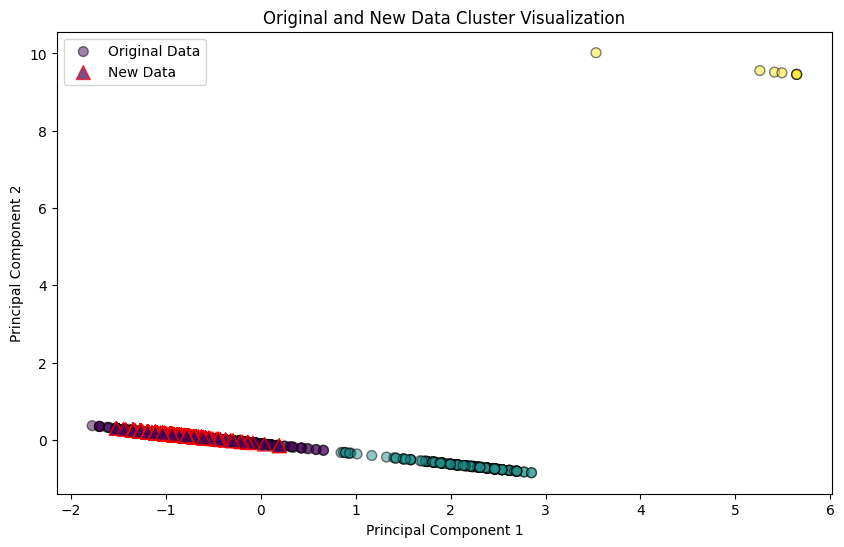

In [44]:
# Assuming 'pca' is the previously fitted PCA instance

# Reduce the new data for visualization
new_reduced_features = pca.transform(new_scaled_features)

# Plot the original clusters and the new data points
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['Cluster'], cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.5, label='Original Data')
plt.scatter(new_reduced_features[:, 0], new_reduced_features[:, 1], c=new_df['Cluster'], cmap='viridis', marker='^', edgecolor='r', s=100, alpha=0.7, label='New Data')
plt.title('Original and New Data Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [ ]:
# Assuming 'original_df' is the DataFrame before dropping the 'Time' column
original_new_df['Cluster'] = new_df['Cluster']  # Add the cluster labels to the original DataFrame

# Save the updated DataFrame including 'Time' and 'Cluster' to a new CSV file
original_new_df.to_csv('2023-02-15-OTA-UE0_with_clusters.csv', index=False)

## Hysteresis Algo

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('./CSV/2023-02-15-OTA-UE1_with_clusters.csv')

# Initialize state and counters
current_state = 'Red'  # Assuming starting state is 'Red'
state_counters = {'Green': 0, 'Orange': 0, 'Red': 0}
transition_thresholds = {'Green': 60, 'Orange': 30, 'Red': 0}

actual_states = []  # To keep track of the actual state after applying hysteresis



def reset_counters():
    for key in state_counters:
        state_counters[key] = 0

# Map cluster numbers to state names for clarity
cluster_to_state = {0: 'Green', 1: 'Orange', 2: 'Red'}

# Mapping from color names to numerical identifiers for the 'Actual State' column
state_to_number = {'Green': 0, 'Orange': 1, 'Red': 2}



for index, row in df.iterrows():
    new_cluster_state = cluster_to_state[row['Cluster']]
    
    # Immediate transition to a worse condition
    if (new_cluster_state == 'Orange' and current_state == 'Green') or \
       (new_cluster_state == 'Red' and current_state != 'Red'):
        current_state = new_cluster_state
        reset_counters()
    else:
        # Increment counter for the new state
        state_counters[new_cluster_state] += 1

        # Check for transition back to better conditions with memory
        if current_state == 'Red' and new_cluster_state == 'Orange' and state_counters['Orange'] >= transition_thresholds['Orange']:
            current_state = 'Orange'
            reset_counters()
        elif current_state == 'Orange' and new_cluster_state == 'Green' and state_counters['Green'] >= transition_thresholds['Green']:
            current_state = 'Green'
            reset_counters()
        elif current_state == 'Red' and new_cluster_state == 'Green' and state_counters['Green'] >= transition_thresholds['Green']:
            # Direct Red to Green transition might require stricter checks
            current_state = 'Green'
            reset_counters()

    # Append the numerical representation of the current actual state to the list
    actual_states.append(state_to_number[current_state])

# Add the actual state column to the DataFrame with numerical identifiers
df['Actual State'] = actual_states

# Save the updated DataFrame back to a CSV file
df.to_csv('2023-02-15-OTA-UE1_with_clusters_Hysteresis_1.csv', index=False)


# Results Visualization

## No FRER

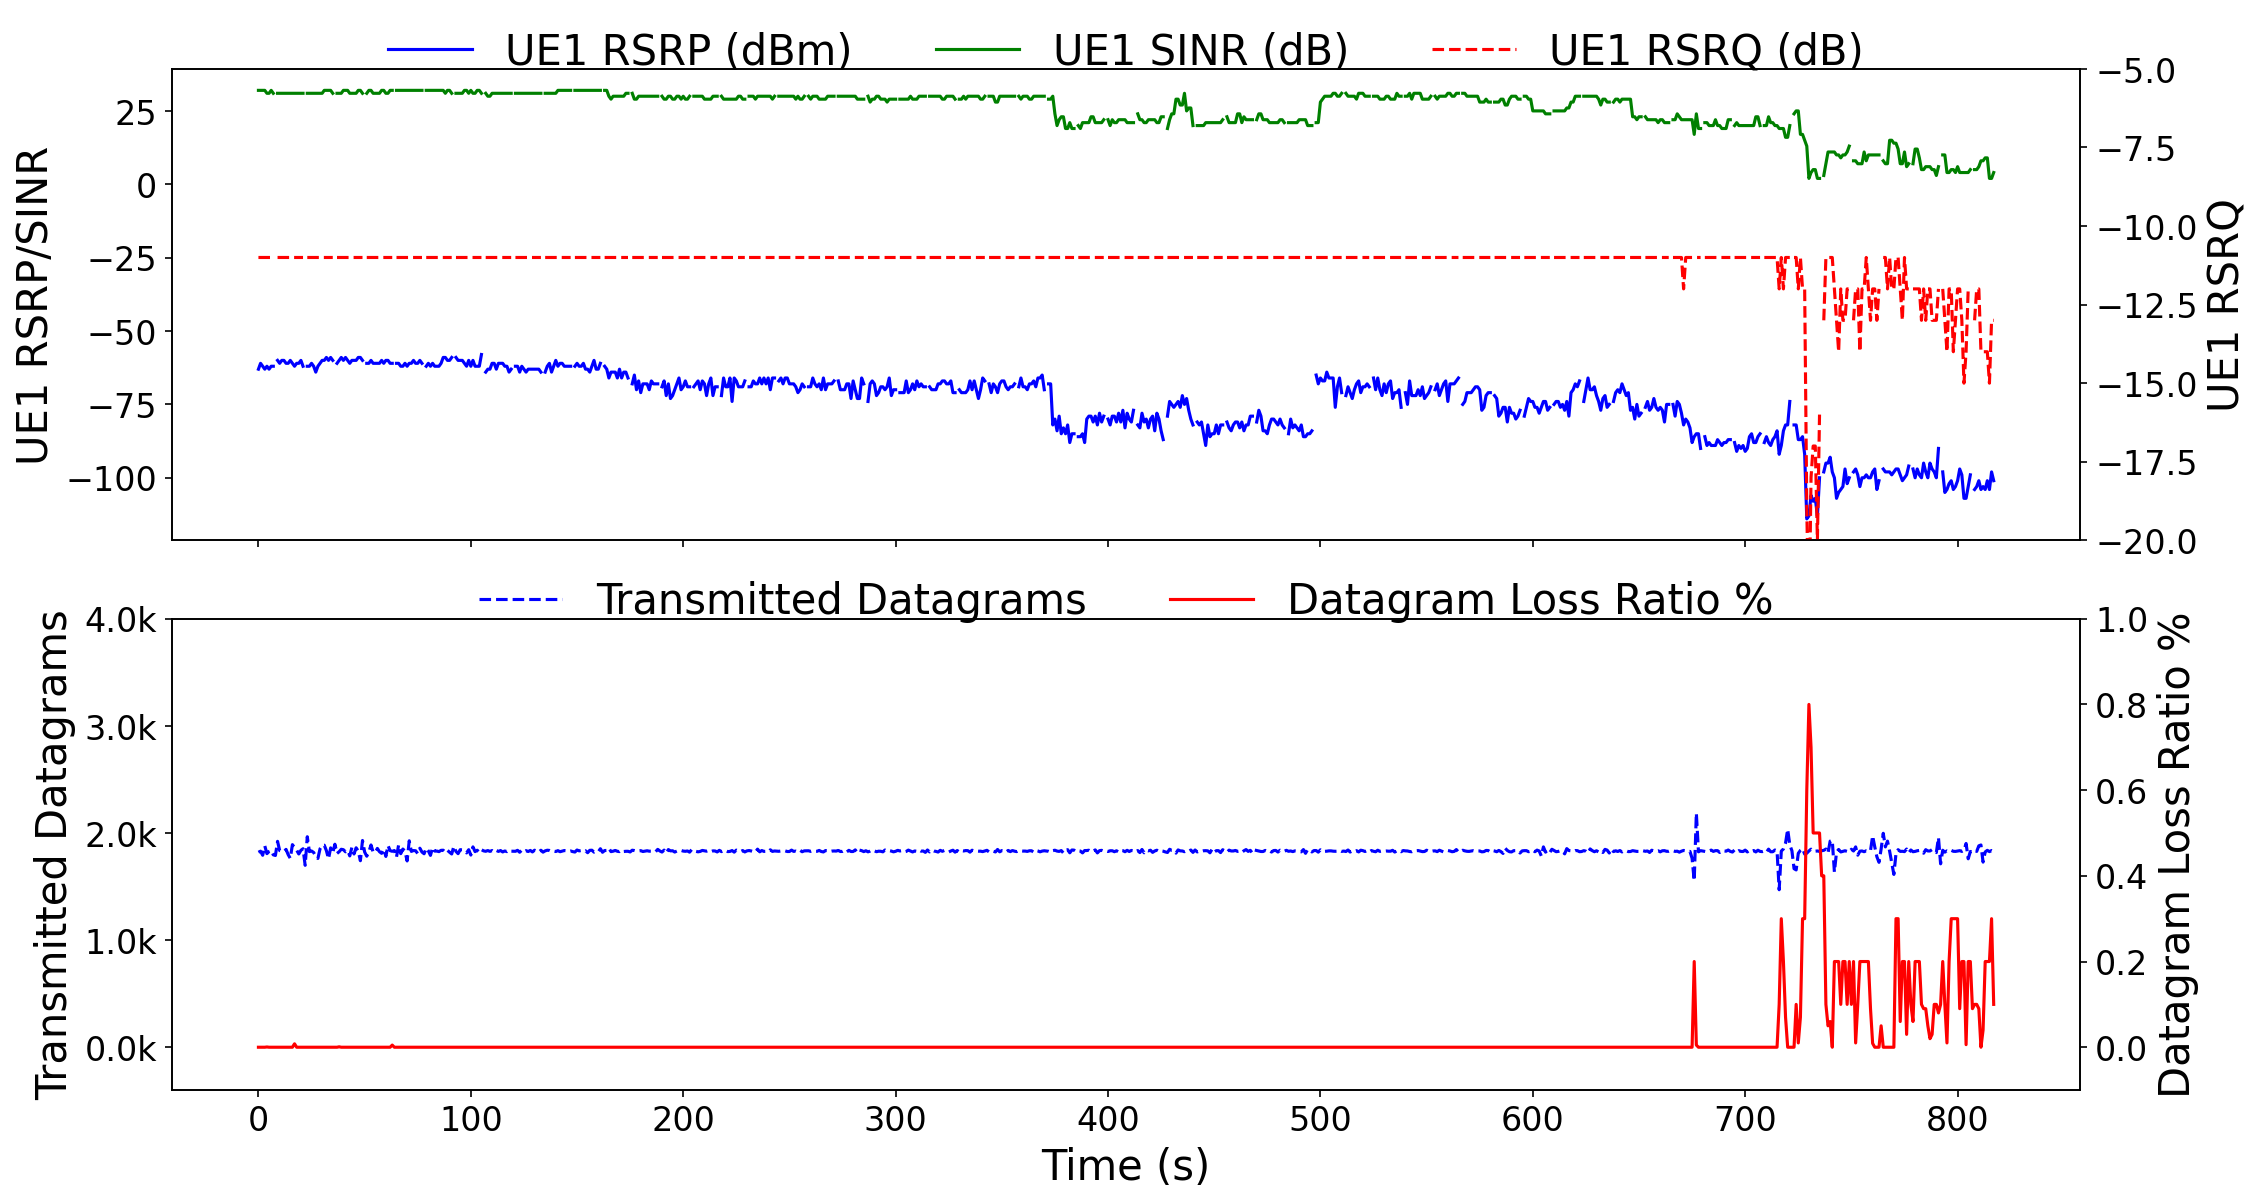

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming your CSV file is named 'data.csv'
df = pd.read_csv('UE1_noFRER_CSV.csv')

# Reset index to make sure we use integer indices for x-axis
df.reset_index(drop=True, inplace=True)

# Function to format the tick labels in thousands
def thousands_formatter(x, pos):
    return f'{x / 1000}k'

# Function to add legend below each subplot
def add_legend(ax, ax2):
    # Collect handles and labels for both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    # Place the combined legend in the middle below the subplot
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3, frameon=False, fontsize=20)



# Create figure and axes
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True, dpi=150)

# Plotting with index values
# UE1 RSRP and SINR with RSRQ on the secondary y-axis
ax1 = axs[0]
ax1.plot(df.index, df['UE1 RSRP'], label='UE1 RSRP (dBm)', color='blue')
ax1.plot(df.index, df['UE1 SINR'], label='UE1 SINR (dB)', color='green')
ax1.set_ylabel('UE1 RSRP/SINR', fontsize=20)

# Create secondary y-axis for RSRQ
ax1_rsrq = ax1.twinx()
ax1_rsrq.plot(df.index, df['UE1 RSRQ'], label='UE1 RSRQ (dB)', color='red', linestyle='--')
ax1_rsrq.set_ylabel('UE1 RSRQ', fontsize=20)
ax1_rsrq.set_ylim(-20,-5)
add_legend(ax1, ax1_rsrq)


# UE1 Total Datagrams and Datagrams Loss Ratio with switched axes
ax2 = axs[1]
# Plot Total Datagrams on the primary y-axis
ax2.plot(df.index, df['UE1 Total Datagrams'], label='Transmitted Datagrams', color='blue', linestyle='--')
ax2.set_ylabel('Transmitted Datagrams', fontsize=20)
ax2.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax2.set_ylim(-400, 4000)  # Adjust as necessary


# Create secondary y-axis for Datagrams Loss Ratio
ax2_2 = ax2.twinx()
ax2_2.plot(df.index, df['UE1 Datagrams Loss Ratio'], label='Datagram Loss Ratio %', color='red')
ax2_2.set_ylabel('Datagram Loss Ratio %', fontsize=20)
ax2.set_xlabel('Time (s)',fontsize=20)
ax2_2.set_ylim(-0.1,1)
add_legend(ax2, ax2_2)




# Set the desired font size for tick labels
font_size = 16  # Example font size, adjust as needed

# Increase font size of the numbers on the y and x axes for all primary subplots
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=font_size)

# Explicitly set font size for secondary y-axes created with twinx()
for ax_twin in [ax1_rsrq, ax2_2]:
    ax_twin.tick_params(axis='y', which='major', labelsize=font_size)



#plt.tight_layout(rect=[0, 0.03, 1, 1])  # Adjust the overall layout
plt.subplots_adjust(hspace=0.2)  # Adjust space between subplots if necessary



# Formatting
plt.subplots_adjust(hspace=0.3, bottom=0.2)
plt.tight_layout()

# plt.savefig("noFRERscenario.pdf")
plt.show()


## w/ FRER

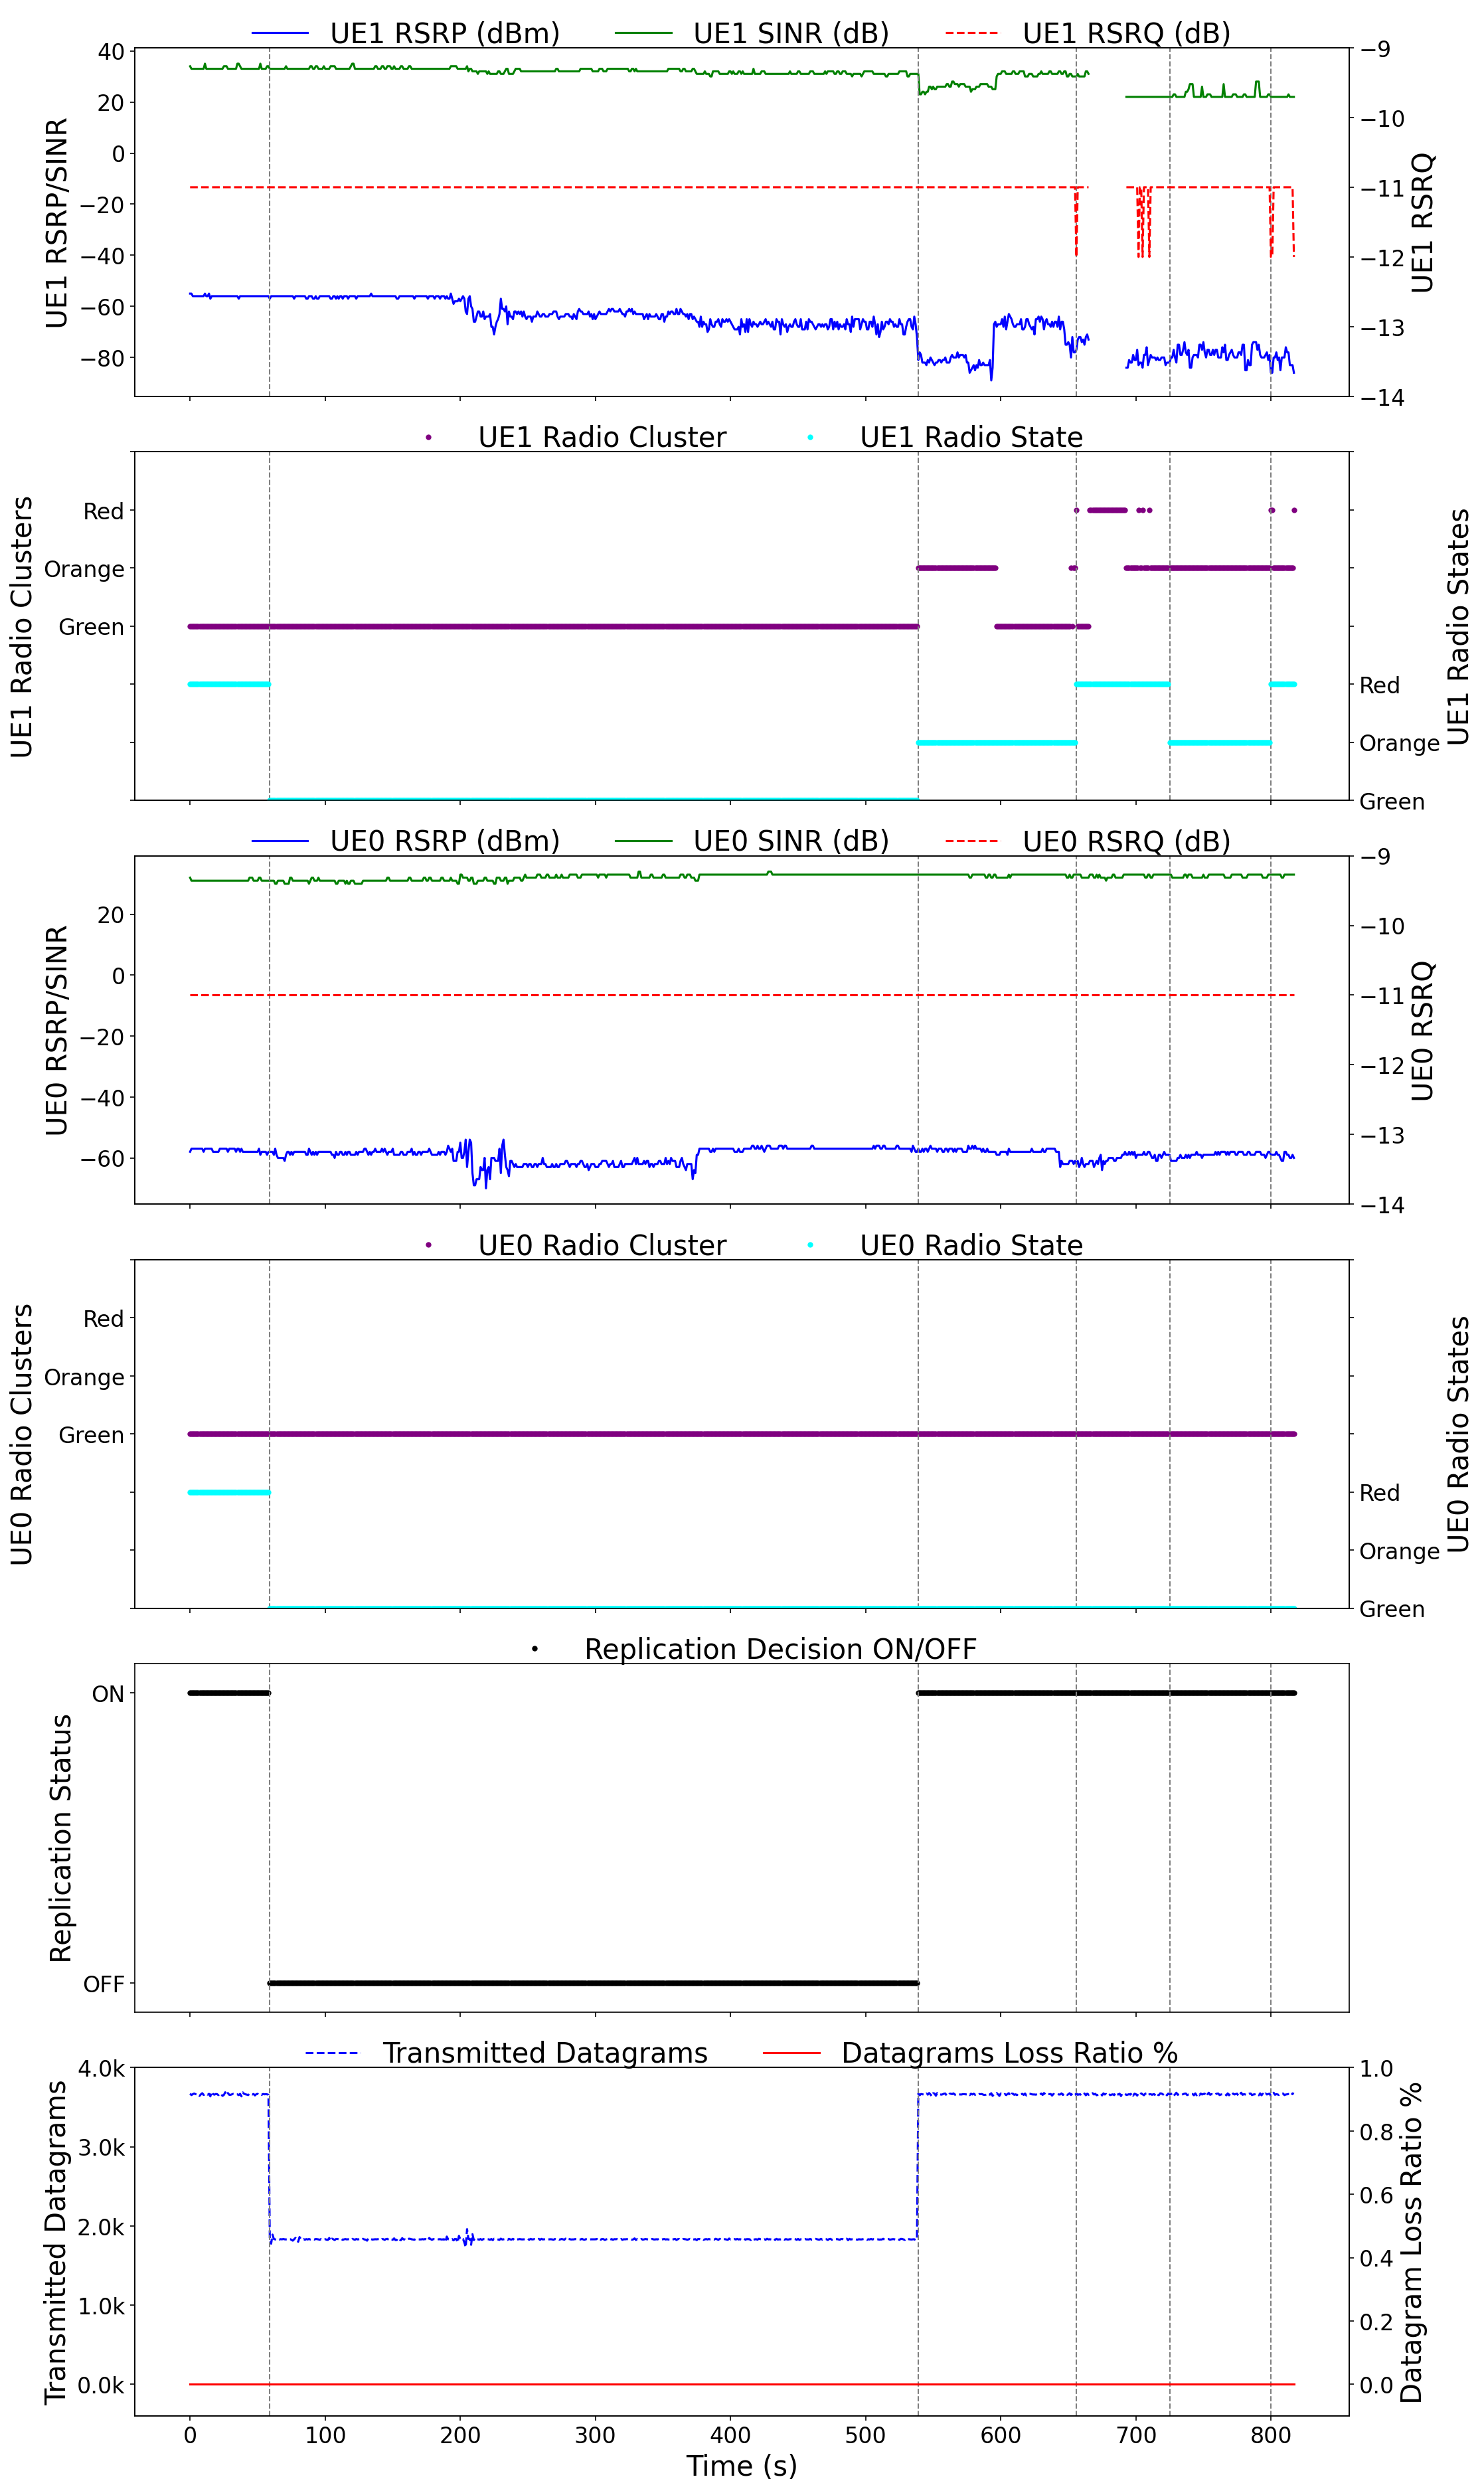

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load the CSV file
df = pd.read_csv('./CSV/ml-FRER-vis.csv')

# Function to format the tick labels in thousands
def thousands_formatter(x, pos):
    return f'{x / 1000}k'


# Function to add legend below each subplot
def add_legend(ax, ax2):
    # Collect handles and labels for both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    # Place the combined legend in the middle below the subplot
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, fontsize=20)








# Increase the subplot size to accommodate the new cluster info plots
fig, axs = plt.subplots(6, 1, figsize=(15, 25), sharex=True, dpi=150)




# UE1 Radio Conditions with <RSRQ> on secondary Y axis
ax1 = axs[0]
ax1_rsrq = ax1.twinx()
ax1.plot(df.index, df['UE1<RSRP>'], label='UE1 RSRP (dBm)', color='blue')
ax1.plot(df.index, df['UE1<SINR>'], label='UE1 SINR (dB)', color='green')

ax1.set_ylabel('UE1 RSRP/SINR', fontsize=20)
ax1_rsrq.plot(df.index, df['UE1<RSRQ>'], label='UE1 RSRQ (dB)', color='red', linestyle='--')

ax1_rsrq.set_ylabel('UE1 RSRQ', color='black', fontsize=20)
ax1_rsrq.set_ylim(-14,-9)
add_legend(ax1, ax1_rsrq)



# Plotting UE1 Cluster Info
axs[1].plot(df.index, df['UE1-Cluster'], label='UE1 Radio Cluster', color='purple', marker='.', linestyle='None')
axs[1].set_ylabel('UE1 Radio Clusters', fontsize=20)
axs[1].set_ylim(-3, 3)  # Adjust to include all cluster values
axs[1].set_yticks([-3, -2, -1 , 0 , 1, 2, 3])  # Set y-ticks to correspond to the binary values
axs[1].set_yticklabels(['', '', '', 'Green', 'Orange', 'Red', ''])  # Replace 0 with 'OFF' and 1 with 'ON'

# Create a secondary y-axis for UE1-Cluster-Hist on the same subplot as UE1 Cluster
ax1_cluster_hist = axs[1].twinx()
ax1_cluster_hist.plot(df.index, df['UE1-Cluster-Hist'], label='UE1 Radio State', color='cyan', marker='.', linestyle='None')
ax1_cluster_hist.set_ylabel('UE1 Radio States', color='black', fontsize=20)
ax1_cluster_hist.set_ylim(0, 6)  # Assuming the cluster history values are similar to cluster values
# Replace numerical y-axis labels with text
ax1_cluster_hist.set_yticks([0, 1, 2, 3, 4, 5, 6])  # Set y-ticks to correspond to the binary values
ax1_cluster_hist.set_yticklabels(['Green', 'Orange', 'Red', '', '', '', ''])  



add_legend(axs[1], ax1_cluster_hist)


# UE0 Radio Conditions and Cluster with <RSRQ> on secondary Y axis
ax2 = axs[2]
ax2_rsrq = ax2.twinx()
ax2.plot(df.index, df['UE0<RSRP>'], label='UE0 RSRP (dBm)', color='blue')
ax2.plot(df.index, df['UE0<SINR>'], label='UE0 SINR (dB)', color='green')
ax2_rsrq.plot(df.index, df['UE0<RSRQ>'], label='UE0 RSRQ (dB)', color='red', linestyle='--')
ax2.set_ylabel('UE0 RSRP/SINR', fontsize=20)
ax2_rsrq.set_ylabel('UE0 RSRQ', color='black', fontsize=20)
ax2_rsrq.set_ylim(-14,-9)
add_legend(ax2, ax2_rsrq)


# Plotting UE0 Cluster Info
# UE0 Cluster Info with UE0-Cluster-Hist on secondary Y axis
ax3 = axs[3]
ax3_hist = ax3.twinx()
ax3.plot(df.index, df['UE0-Cluster'], label='UE0 Radio Cluster', color='purple', marker='.', linestyle='None')
ax3_hist.plot(df.index, df['UE0-Cluster-Hist'], label='UE0 Radio State', color='cyan', marker='.', linestyle='None')
ax3.set_ylabel('UE0 Radio Clusters', fontsize=20)
ax3.set_ylim(-3, 3)  # Adjust to include all cluster values

# Replace numerical y-axis labels with text
ax3.set_yticks([-3, -2, -1 , 0 , 1, 2, 3])  # Set y-ticks to correspond to the binary values
ax3.set_yticklabels(['', '', '', 'Green', 'Orange', 'Red', ''])  # Replace 0 with 'OFF' and 1 with 'ON'


ax3_hist.set_ylabel('UE0 Radio States', color='black', fontsize=20)
ax3_hist.set_ylim(0, 6)  # Assuming the cluster history values are similar to cluster values

# Replace numerical y-axis labels with text
ax3_hist.set_yticks([0, 1, 2, 3, 4, 5, 6])  # Set y-ticks to correspond to the binary values
ax3_hist.set_yticklabels(['Green', 'Orange', 'Red', '', '', '', ''])  


add_legend(ax3, ax3_hist)






# # Assuming FRER Replication Status and Datagram Loss Ratio plots remain the same,
# # FRER Replication Status
ax3 = axs[4]
ax3.step(df.index, df['Replication ON/OFF'], label='Replication Decision ON/OFF', where='post', color='black', marker='.', linestyle='None')
ax3.set_ylabel('Replication Status', fontsize=20)
ax3.set_ylim(-0.1, 1.1)  # Adjusting y limits for clarity
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, fontsize=20)
# Replace numerical y-axis labels with text
ax3.set_yticks([0, 1])  # Set y-ticks to correspond to the binary values
ax3.set_yticklabels(['OFF', 'ON'])  # Replace 0 with 'OFF' and 1 with 'ON'






# Datagram Loss Ratio now plotted on secondary Y axis, and Transmitted Datagrams on the primary Y axis
ax4 = axs[5]  # Primary axis for Transmitted Datagrams
ax4_loss_ratio = ax4.twinx()  # New secondary y-axis for Datagram Loss Ratio %

# Plot Transmitted Datagrams on the primary Y axis, applying the formatter for thousands
ax4.plot(df.index, df['Transmitted Datagrams'], label='Transmitted Datagrams', color='blue', linestyle='--')
ax4.set_ylabel('Transmitted Datagrams', color='black', fontsize=20)
ax4.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax4.set_ylim(-400, 4000)  # Adjust as necessary


# Plot Datagram Loss Ratio % on the secondary Y axis
ax4_loss_ratio.plot(df.index, df['Datagrams Loss Ratio %'], label='Datagrams Loss Ratio %', color='red')
ax4_loss_ratio.set_ylabel('Datagram Loss Ratio %', color='black', fontsize=20)
ax4_loss_ratio.set_ylim(-0.1, 1)

# Set x-axis label
ax4.set_xlabel('Time (s)',fontsize=20)

# Assuming add_legend function is adapted to work with the swapped axes
add_legend(ax4, ax4_loss_ratio)










# Define a list of x-coordinates for the vertical lines
x_indices = [59, 539, 656, 725, 800]  # Example indices, adjust to your needs

# Add vertical lines at specified x-coordinates on all subplots
for ax in axs:
    # Iterate over each specified x-coordinate
    for x_index in x_indices:
        ax.axvline(x=x_index, color='gray', linestyle='--', linewidth=1)
    # If the subplot has a twin y-axis, add the line there as well
    if hasattr(ax, 'twinx_ax'):  # Assuming you've attached twin axes as a custom attribute
        for x_index in x_indices:
            ax.twinx_ax.axvline(x=x_index, color='gray', linestyle='--', linewidth=1)

# Set the desired font size for tick labels
font_size = 16  # Example font size, adjust as needed

# Increase font size of the numbers on the y and x axes for all primary subplots
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=font_size)

# Explicitly set font size for secondary y-axes created with twinx()
for ax_twin in [ax1_rsrq, ax2_rsrq, ax1_cluster_hist, ax3_hist, ax4_loss_ratio]:
    ax_twin.tick_params(axis='y', which='major', labelsize=font_size)



#plt.tight_layout(rect=[0, 0.03, 1, 1])  # Adjust the overall layout
plt.subplots_adjust(hspace=0.2)  # Adjust space between subplots if necessary

plt.tight_layout()
plt.savefig("AIO_figure.pdf")

plt.show()



C:\Users\emohaub\AppData\Local\Temp\ipykernel_30308\1345459565.py:78: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=200)  # adjust interval as needed


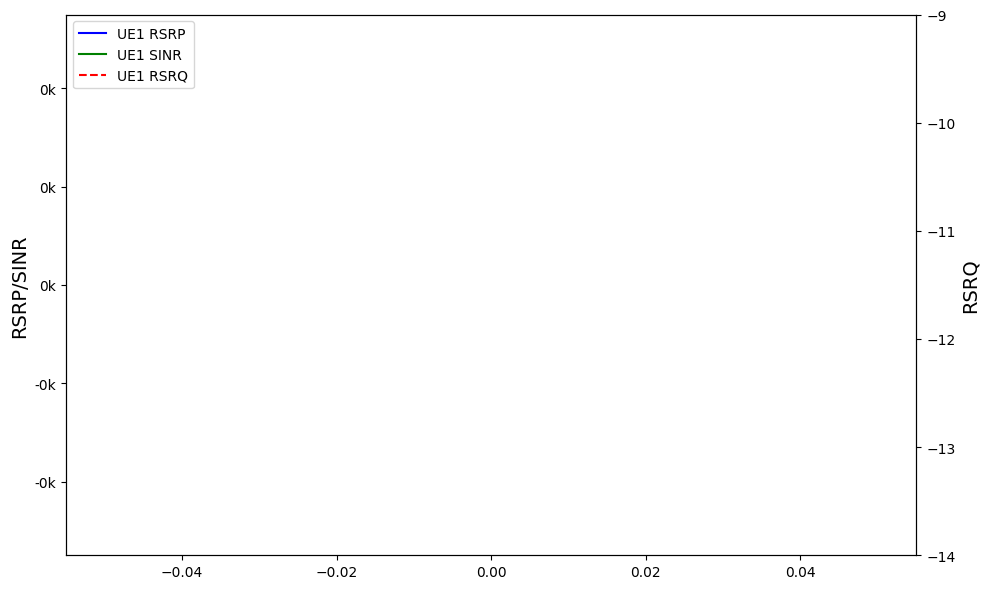

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter

# File path
csv_path = './CSV/ml-FRER-vis.csv'

# Generator to read CSV line-by-line
def csv_row_generator(filepath):
    with open(filepath) as f:
        # Skip header
        header = f.readline().strip().split(',')
        for line in f:
            row = line.strip().split(',')
            yield dict(zip(header, row))

# Formatter
def thousands_formatter(x, pos):
    return f'{x / 1000:.0f}k'

# Storage for data
data = {
    'index': [],
    'UE1<RSRP>': [],
    'UE1<SINR>': [],
    'UE1<RSRQ>': []
    # Add more columns as needed
}

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 6))
ax_rsrq = ax.twinx()

# Initial empty plots
line_rsrp, = ax.plot([], [], label='UE1 RSRP', color='blue')
line_sinr, = ax.plot([], [], label='UE1 SINR', color='green')
line_rsrq, = ax_rsrq.plot([], [], label='UE1 RSRQ', color='red', linestyle='--')

ax.set_ylabel('RSRP/SINR', fontsize=14)
ax_rsrq.set_ylabel('RSRQ', fontsize=14)
ax_rsrq.set_ylim(-14, -9)
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Generator instance
row_gen = csv_row_generator(csv_path)

# Update function
def update(frame):
    try:
        row = next(row_gen)
        idx = len(data['index'])
        data['index'].append(idx)
        data['UE1<RSRP>'].append(float(row['UE1<RSRP>']))
        data['UE1<SINR>'].append(float(row['UE1<SINR>']))
        data['UE1<RSRQ>'].append(float(row['UE1<RSRQ>']))

        # Update data in plots
        line_rsrp.set_data(data['index'], data['UE1<RSRP>'])
        line_sinr.set_data(data['index'], data['UE1<SINR>'])
        line_rsrq.set_data(data['index'], data['UE1<RSRQ>'])

        # Update axes
        ax.set_xlim(0, len(data['index']))
        ax.set_ylim(min(data['UE1<RSRP>']), max(data['UE1<RSRP>']))
        ax_rsrq.set_ylim(-14, -9)  # Keep fixed or adapt if needed
        return line_rsrp, line_sinr, line_rsrq
    except StopIteration:
        ani.event_source.stop()  # Stop animation when file ends
        return []

# Add legend
lines = [line_rsrp, line_sinr, line_rsrq]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

# Create animation
ani = FuncAnimation(fig, update, interval=200)  # adjust interval as needed
plt.tight_layout()
plt.show()
